## **Part 5**
(**40 points**; Due Monday December 13th at 11:59pm; PDF of Jupyter Notebook) **Perform the planned analyses** (be sure to note in markdown if there were any changes to your analysis plan since part #3 and **why**), and **make the graphs in a python notebook**. You should also include written (in markdown) answers to each of the 3 questions that you asked:

<ul>
    <li> a) <b>the analysis code.</b>
    <li> b) <b>explicit answer to the question with detailed responses of how you came to this answer and the answer's importance.</b> This should be targeted at an audience that are NOT familiar with Data Science (e.g. pretend you're presenting these results to shareholders/your boss).
    <li> c) <b>two ggplot data visualizations + captions</b> (graphs will be graded on how efficient and clear they are, so make sure you make good aesthetic choices that help emphasize your message).
</ul>


Answers should be clear, concise, and complete. You will be graded on your code, the clarity of your responses, and the correctness of your methods. Save that notebook as a PDF. You must clearly label each question and the analyses that apply to it using Markdown. Don't forget to turn in a README with this part.

## **Your Song**

Our compnay wants to use the Spotify API in order to promote songs to its customers based on what kind of music they like to listen to. To do this, we are using the assumptions of `valence`, `energy`, `mode` provided by the Spotify API to classify each song as Happy, Angry, Calm or Sad. 

### Variables
- `valence`: describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- `energy`: represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
- `mode`: indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. 
    - **major** keys use a major scale and typically have a bright, happy, and cheerful melody 
    - **minor** keys use a minor scale and usually sound more melancholy and sad.

In [1]:
# import python packages needed
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import sklearn as sk
from local import config as local_conf

from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

from sklearn.mixture import GaussianMixture

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split # simple TT split cv

import statsmodels.api as sm
from sklearn.decomposition import PCA

%matplotlib inline 

In [2]:
# create our connection to the API
username = "megraswan" # username

In [3]:
# connect
client_credentials_manager = SpotifyClientCredentials(local_conf.CLIENT_ID, local_conf.CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
# playlist ID you would like to get track data from 
# Meghna-Playlist playlist 
pl_id = 'spotify:playlist:0NNhXpFW80b1LK3kVCO05R'

# playlist_items() gets each item from the playlist
response = sp.playlist_items(pl_id,
                                limit=1, # maximum number of tracks to return
                                offset=0, # the index of the first track to return
                                fields='total', # which fields to return
                                additional_types=['track']) # list of item types to return (we want tracks)
total_num_tracks = response['total'] # total_num_tracks stores total number of tracks in playlist

offset = 0 # will act as a pointer after every 100 tracks we go through
limit = 100

dfs = [] # data frames list
for n in range(int(total_num_tracks/limit)+1): # we want to iterate 10 times bc we have 909 tracks in this cases (we will get data for every 100 tracks each loop)
    response = sp.playlist_items(pl_id,
                                limit=limit,
                                offset=offset, 
                                fields='items.track.id,items.track.name,items.track.artist,items.track.track_number,items.track.duration_ms,items.track.id,total',
                                additional_types=['track']) 

    track_ids = []
    tracks = []    
    for item in response['items']: # item is a dictionary that has dictionaries
        track_ids.append(item['track']['id']) # in the dictionary "item", we are getting the value for key "id" from dictionary "track"
        # {"items": {"track": {"id": '17CPezzLWzvGfpZW6X8XT0'}}}
        # storing dictionary in track_info
        track_info = {  "name":item['track']['name'],
                        "duration_ms":item['track']['duration_ms'],
                        "track_number":item['track']['track_number']    }
        # {"items": {"track": {"name": 'Say You, Say Me'}}}
        # {"items": {"track": {"duration_ms": 241066}}}
        # {"items": {"track": {"track_number": 8}}}
        tracks.append(track_info)

    # get audio features from each track id from track_ids list
    features = sp.audio_features(tracks=track_ids)

    # for every rack, add/combine features list items to tracks list (both have dictionaries so we combine dictionaries)
    for idx in range(len(tracks)):
        tracks[idx].update(features[idx]) 

    df = pd.DataFrame(tracks) # create data frame df of tracks list
    dfs.append(df) # add data frame to dfs list

    if len(response['items']) == 0: # if no items, exit loop
        break

    offset = offset + len(response['items']) # increment offset by length of items in loop (move pointer every 100 items until it reaches end of tracks)

# Put all songs in 1 DataFrame
df_combo = pd.concat(dfs) # combine the data frames in the dfs list to 1 data frame
df_combo.head() # print first few rows of data frame

,name,duration_ms,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,time_signature
0,Hey Jude - Remastered 2015,425653,21,0.386,0.607,10,-7.700,1,0.0261,0.0112,0.000014,0.0880,0.532,147.207,audio_features,0aym2LBJBk9DAYuHHutrIl,spotify:track:0aym2LBJBk9DAYuHHutrIl,https://api.spotify.com/v1/tracks/0aym2LBJBk9D...,https://api.spotify.com/v1/audio-analysis/0aym...,4
1,Here Comes The Sun - Remastered 2009,185733,7,0.557,0.540,9,-10.484,1,0.0347,0.0339,0.002480,0.1790,0.394,129.171,audio_features,6dGnYIeXmHdcikdzNNDMm2,spotify:track:6dGnYIeXmHdcikdzNNDMm2,https://api.spotify.com/v1/tracks/6dGnYIeXmHdc...,https://api.spotify.com/v1/audio-analysis/6dGn...,4
2,Highway to Hell,208400,1,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.1560,0.423,115.728,audio_features,2zYzyRzz6pRmhPzyfMEC8s,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,4
3,Back In Black,255493,6,0.310,0.700,9,-5.678,1,0.0470,0.0110,0.009650,0.0828,0.763,188.386,audio_features,08mG3Y1vljYA6bvDt4Wqkj,spotify:track:08mG3Y1vljYA6bvDt4Wqkj,https://api.spotify.com/v1/tracks/08mG3Y1vljYA...,https://api.spotify.com/v1/audio-analysis/08mG...,4
4,Livin' On A Prayer,249293,3,0.534,0.887,0,-3.777,1,0.0345,0.0768,0.000099,0.3250,0.720,122.494,audio_features,0J6mQxEZnlRt9ymzFntA6z,spotify:track:0J6mQxEZnlRt9ymzFntA6z,https://api.spotify.com/v1/tracks/0J6mQxEZnlRt...,https://api.spotify.com/v1/audio-analysis/0J6m...,4


In [5]:
df_combo.shape

(1003, 20)

In [6]:
# nothing is missing wooooooo
df_combo.isnull().mean()

name                0.0
duration_ms         0.0
track_number        0.0
danceability        0.0
energy              0.0
key                 0.0
loudness            0.0
mode                0.0
speechiness         0.0
acousticness        0.0
instrumentalness    0.0
liveness            0.0
valence             0.0
tempo               0.0
type                0.0
id                  0.0
uri                 0.0
track_href          0.0
analysis_url        0.0
time_signature      0.0
dtype: float64

In [7]:
# creating That's So 80's spotify playlist
df_combo.to_csv ('spotify_playlist_meghna.csv', index = False, header=True)

## 1. Journalist Miriam Quick performed an investigation to identify the saddest and the happiest songs ever listed on the top of the Billboard singles chart. To conduct this investigaiton, Quick used numerical parameters of valence and energy, provided by the Spotify Web API. Spotify's internal algorithm measures valence from 0 to 1 based on positive or negative moods, while energy, which is also measured from 0 to 1, indicates how lively and dynamic a song is. As we can see in the scatterplot below, Quick splits the graph into 4 quadrants of mood (Happy, Angry, Calm and Sad) based on the valence and energy of each song. Based on this investigation, would **Gaussian Mixture Models (EM)** be able to accurately cluster the data into the 4 quadrants of mood given the `valence` and `energy`? If not, what other assumptions can we make of the clusters (meaning what characterizes each cluster)?

<img src="canzoni_distr.jpeg">

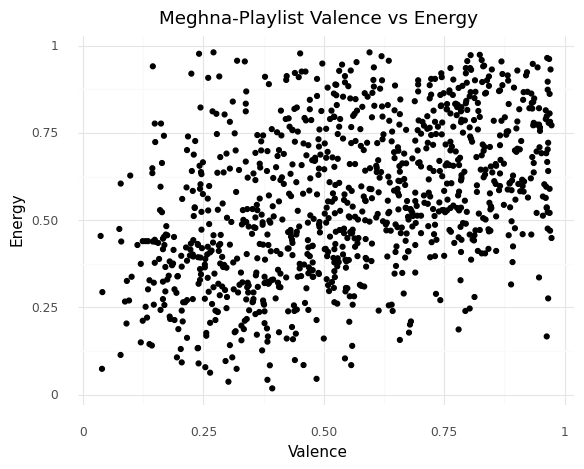

<ggplot: (8791500101777)>

In [8]:
# and use plotnine/ggplot to make a scatterplot of the data 
(ggplot(df_combo, aes("valence","energy")) + geom_point() + theme_minimal() + theme(legend_position = "none") + 
labs(title = "Meghna-Playlist Valence vs Energy") +
xlab("Valence") + ylab("Energy"))

In [13]:
contVals = ['valence','energy']
X1 = df_combo[contVals]
X1.head()

,valence,energy
0,0.532,0.607
1,0.394,0.540
2,0.423,0.913
3,0.763,0.700
4,0.720,0.887


In [14]:
# no need to z-score valence and energy because both features are already on the same scale
GMX1df = X1
gm1 = GaussianMixture(n_components = 4)
gm1.fit(X1)
colName = "4_assign"
GM1clusters = gm1.predict(X1)
GMX1df[colName] = GM1clusters
print("Gaussian Mixture SILHOUETTE (4 components):", silhouette_score(X1, GM1clusters))

Gaussian Mixture SILHOUETTE (4 components): 0.81851887591075


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
GMX1df.head()

,valence,energy,4_assign
0,0.532,0.607,3
1,0.394,0.540,1
2,0.423,0.913,2
3,0.763,0.700,0
4,0.720,0.887,0


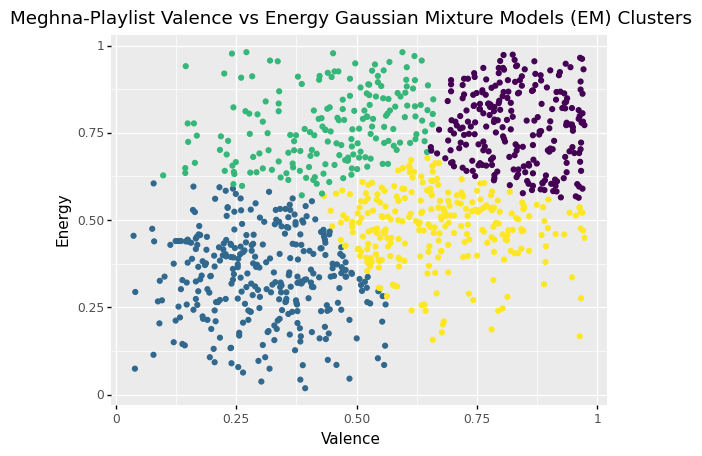

<ggplot: (8791505913529)>

In [16]:
cluster_col = "4_assign"
(ggplot(GMX1df, aes(x = "valence", y = "energy", color = cluster_col)) + geom_point() + 
theme(legend_position = "none") + 
labs(title = "Meghna-Playlist Valence vs Energy Gaussian Mixture Models (EM) Clusters") +
xlab("Valence") + ylab("Energy"))

<img src="canzoni_distr.jpeg">

### What steps I took and why:

In order to try and replicate these certain clusters, I used the **Gaussian Mixture Models (EM)** clustering algorithm because it will use soft assignments for each of the data points, meaning that it assigns each data point a probability of being assigned to each cluster. So, the data points that are unlikely to belong to a cluster barely affect the center/mean and variance of that cluster, whereas data points that are very likely to belong to a cluster have a larger influence on the center/mean and variance of that cluster.

In this case, **Gaussian Mixture Models (with EM)** is a good clustering model to use because since the algorithm assumes that the clusters are elliptical, the clustering algorithms will be able to cluster specific categories with more felxibility. The clusters that have more of a spread use probabilistic assignments that would help assign the data points in the clusters it is proabable to be in. Using **Gaussian Mixture Model's** elliptical clusters gives us an idea if the probability of the data points that are assigned to each cluster follow Miriam Quick's 4 quadrants of mood trend.

I have chosen 4 components as the hyperparameters because in order to see if the algorithm follows the same trend of 4 quadrants of mood (Happy, Angry, Calm and Sad) as Quick's analysis, we would need to let the algorithm categorize the data given having to make 4 clusters.

### My findings:

Looking at the clustered graph, **Gaussian Mixture Models (EM)** was actually able to colsely replicate Quick's 4 quadrants of moods. We can tell because like the 4 quadrants of moods that were categorized according to `valence` and `energy`, we can assume that:
- the **blue** cluster represents **sad** songs as these songs are low in `valence` and `energy`.
- the **yellow** cluster suggests that these tracks are **calm** because the `valence` for the given songs are realively high and the `energy` is usually low.
- the **green** cluster describes **angry** songs because the songs in this cluster have `valences` that are realtively low and `energies` that are relatively high.
- the **purple** cluster most likely defines **happy** songs since the tracks have high `valence` and `energy`.

Although the graph shows that these data points have high cohesion (meaning the data points are similar/close to their cluster members), but low separation (which is where the clusters are different from other clusters depending on distance), **Gaussian Mixture Models (EM)** use probabilistic assignments that would help assign the data points in the clusters it is proabable to be in. As we can see by the sillhouette score, which is themeasure of both cohesion and separation, the model did quite well with a score of 0.81851887591075. The closer to +1 means that there was good cohesion and separation. 

Since we are able to closely cluster the data to Quick's investigation, we can use these assumptions to recommend either happy, angry, calm and sad songs to our customers depending on the kind music they listen to on their playlist. 

## 2. Since the major and minor keys are usually differentiated by what emotion a song's sounds evoke, is the relationship between `valence` and `energy` different for the `mode` of each track? How can you tell? What can we infer about the relationship between `valence` and `energy` of a song given its `mode`? Meaning, what can we say about a track's 4 quadrants of mood (Happy, Angry, Calm and Sad) based on the relationship between `valence` and `energy` of a song given its `mode`?

In [14]:
threeVals = ['valence','energy','mode']
twoContVals = ['valence','energy']
X2 = df_combo[threeVals]
X2.head()

,valence,energy,mode
0,0.532,0.607,1
1,0.394,0.540,1
2,0.423,0.913,0
3,0.763,0.700,1
4,0.720,0.887,1


In [15]:
GMX2df = X2
gm2 = GaussianMixture(n_components = 4)
gm2.fit(X2[twoContVals])
colName = "4_assign"
GM2clusters = gm2.predict(X2[twoContVals])
GMX2df[colName] = GM2clusters

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
GMX2df.head()

,valence,energy,mode,4_assign
0,0.532,0.607,1,3
1,0.394,0.540,1,1
2,0.423,0.913,0,2
3,0.763,0.700,1,0
4,0.720,0.887,1,0


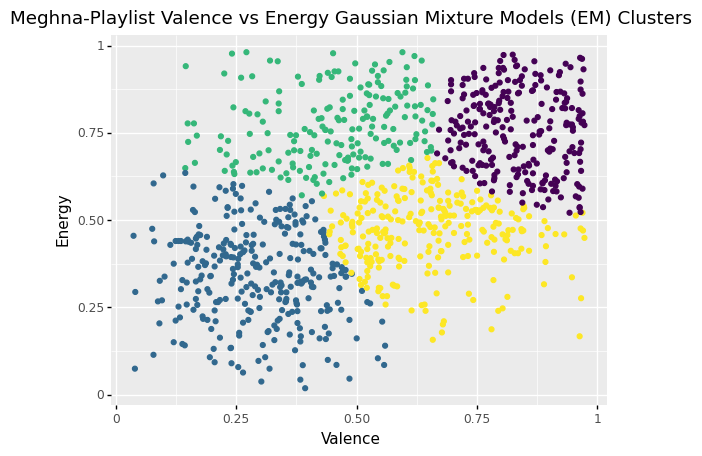

<ggplot: (8761681824933)>

In [36]:
cluster_col = "4_assign"
(ggplot(GMX2df, aes(x = "valence", y = "energy", color = cluster_col)) + geom_point() + 
theme(legend_position = "none") + 
labs(title = "Meghna-Playlist Valence vs Energy Gaussian Mixture Models (EM) Clusters") +
xlab("Valence") + ylab("Energy"))

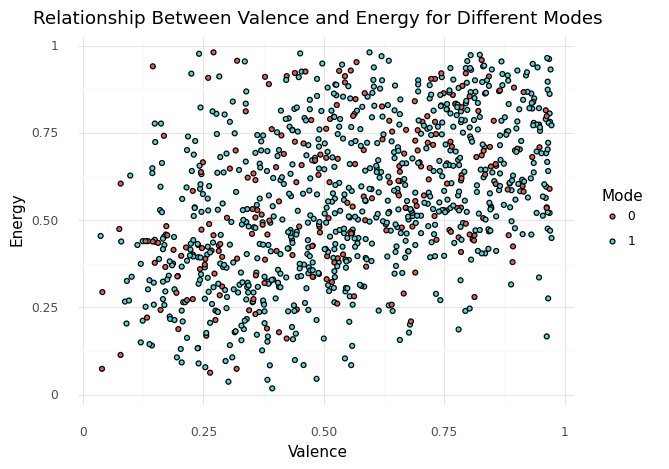

<ggplot: (8761683780477)>

In [39]:
(ggplot(GMX2df, aes(x = "valence", y = "energy", fill = "factor(mode)")) + 
geom_point() + theme_minimal() + xlab("Valence") + 
ylab("Energy") + ggtitle("Relationship Between Valence and Energy for Different Modes") +
labs(fill = "Mode"))

### What steps I took and why:

To see the if `mode` has any relationship with `valence` and `energy` given the clusters that were made by the **Gaussian Mixture Models (with EM)**, I first created a graph plotting the songs by `valence` and `energy` factoring `mode`. This gives us a visual representation if there is more of a concentration of of either major keys or minor keys being used in specific areas in the scatterplot. 

### My findings:

Initially, I guessed that there would be a higher concentration of major keys (when `mode` = 1) in songs with higher `energy` and there would be more of a concentration of minor keys (when `mode` = 0) in songs with lower `energy`. So I was expecting the clusters that indicate angry and happy songs to consist of `modes` with major keys and the clusters that describe sad and calm songs to have `modes` with minor keys. However, in the graph, we can see that there is no clear pattern for the `mode` of a song given its `valence` and `energy`. Both the `modes` seem quite scattered throughout the graph. 

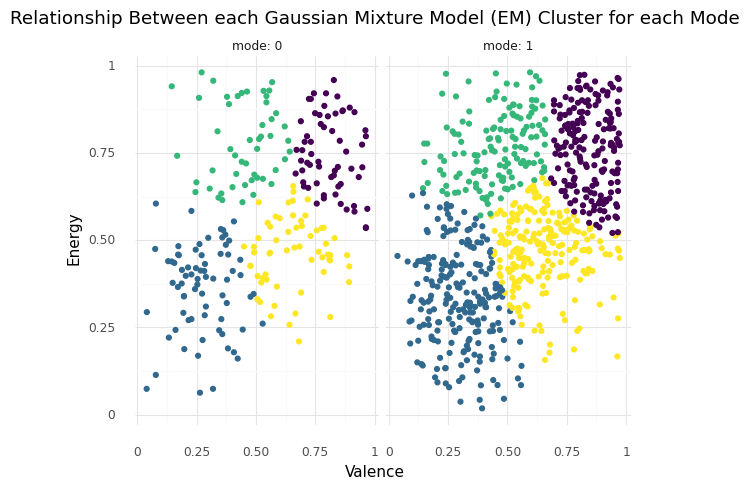

<ggplot: (8761683921445)>

In [38]:
# Danceability across Albumns
(ggplot(GMX2df, aes(x = "valence", y = "energy")) +
 geom_point(aes(color = cluster_col)) +
 theme_minimal() +
 facet_wrap("~mode", scales = "free_x") + 
 labs(title = "Relationship Between each Gaussian Mixture Model (EM) Cluster for each Mode") +
 theme(legend_position = "none") + xlab("Valence") + ylab("Energy") +
 facet_grid("~mode", labeller = label_both))

### What steps I took and why:

To get a clearer idea if the `mode` is more concentrated in certain clusters, I made 2 scatterplots: one where the `mode` is 0 (so the songs use a major key) and one where the `mode` is 1 (so the songs use a minor key). Each scatterplot will use the clusters made by the **Gaussian Mixture Models (with EM)** so that we can see which songs with a `mode` of 0 belongs to which cluster and which songs with a `mode` of 1 belongs to which cluster. 

### My findings:

From what we can see in this graph, there doesn't seem to be specific clusters that either a `mode` of 0 or a `mode` of 1 belong to. The `modes` of 0 and `modes` of 1 seem to belong to all clusters that represent happy, angry, calm and sad songs. Although there is no certain pattern of `mode` belonging to specific clusters, we can instead interpret that there ar more songs in this playlist that consist of songs that use major keys than songs that use minor keys as there are more data points in the scatterplot where `mode` equals 1.

### How these findings will affect how we approach recommending songs to our customers:

Even though we initially assumed that `mode` will be more concentrated in certain clusters (such as the songs with a `mode` of 1 will belong to the angry and happy clusters whereas the songs with a `mode` of 0 will belong to the sad and calm clusters), our assumptions were proved to be false as each `mode` belonged to all the clusters. This means that while recommending songs to our customers, there is no need to really take `mode` into consideration because whether we would like to promote happy, angry, calm or sad songs, `mode` will not have any significant affect on this recommendations.

## 3. Using **Logistic Regression Model**, predict the `mode` (major or minor) of each track. With **Logistic Regression Model**, record the accuracy score for both training/test sets. Discuss the performance of the model. Build a NEW **Logistic Regression Model**, but using **PCA**. Fit your model using the components you found using a scree plot and record the accuracy score for both training/test sets. Discuss how the performance of the model built using **PCA** differs from the model built just using **Logistic Regression Model**. Use a Train-Test-Split with a 90/10 split.

In [20]:
# predictor values
cont_features = ["duration_ms","danceability","energy","loudness","speechiness","acousticness",
            "instrumentalness","liveness","valence","tempo"]

#outcome values
outcome = ["mode"]

# predictors
X = df_combo[cont_features]
# outcomes
y = df_combo[outcome]

#Use TTS with a 90/10 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

z = StandardScaler()

# z-score your predictors
# ONLY FIT ON TRAINING SET
# transform train and test set to get the actual z-score 
X_train[cont_features] = z.fit_transform(X_train[cont_features])
X_test[cont_features] = z.transform(X_test[cont_features])

# create empty logistic reg model
lr = LogisticRegression()
# fit the model
lr.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression()

Logistic Regression Train:  0.7527716186252772
Logistic Regression Test:  0.801980198019802


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


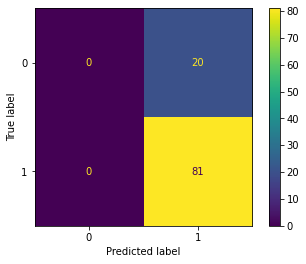

In [21]:
# record the accuracy score for both training/test sets

predsTrain = lr.predict(X_train) 
predsTest = lr.predict(X_test) 

print("Logistic Regression Train: ", accuracy_score(y_train,predsTrain))
print("Logistic Regression Test: ", accuracy_score(y_test,predsTest))

plot_confusion_matrix(lr, X_test, y_test)

### My findings for the **Logistic Regression**: 

The **Logistic Regression** model performed pretty good, but could be better based on its accuracy score of 0.7527716186252772 for the training set and 0.801980198019802 for the test set. he accuracy score determines whether the predicted category from the model match the actual category form the data. Looking at the accuracy scores for the train and test sets, our model is doing pretty well, meaning that our model is doing pretty well in predicting the `mode` of each song. We can also tell that there is no overfitting becuase if there was overfitting, the train test would probably have a higher score than the test set, meaning that the model is too atuned to the training set's data and is not equipped to accurately predict values for unseen data.

Looking at the confusion matrix, the **Logistic Regression** model is predicting whether a song is in major key more and rarely predicting when the songs are in minor key. This type of prediction is creating an imbalance on the off diagonal. Our models would be performing much better if it was making more accurate predictions when the predicted value is 0 (meaning the song is in minor key), and the true value would also be 0. Same goes for when predciting a song that is in major key, and correspondinly more of the true values of the predictions will also be 1 (a song that is in major key). However, when looking at the confusion matrix, we can see that the model can accurately predict for when a song is on a major scale, but is less accurate when it comes to predicting a song on a minor scale.

In [25]:
dfPCA = pd.read_csv("spotify_playlist_meghna.csv")
dfPCA.head()

,name,duration_ms,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,time_signature
0,Hey Jude - Remastered 2015,425653,21,0.386,0.607,10,-7.700,1,0.0261,0.0112,0.000014,0.0880,0.532,147.207,audio_features,0aym2LBJBk9DAYuHHutrIl,spotify:track:0aym2LBJBk9DAYuHHutrIl,https://api.spotify.com/v1/tracks/0aym2LBJBk9D...,https://api.spotify.com/v1/audio-analysis/0aym...,4
1,Here Comes The Sun - Remastered 2009,185733,7,0.557,0.540,9,-10.484,1,0.0347,0.0339,0.002480,0.1790,0.394,129.171,audio_features,6dGnYIeXmHdcikdzNNDMm2,spotify:track:6dGnYIeXmHdcikdzNNDMm2,https://api.spotify.com/v1/tracks/6dGnYIeXmHdc...,https://api.spotify.com/v1/audio-analysis/6dGn...,4
2,Highway to Hell,208400,1,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.1560,0.423,115.728,audio_features,2zYzyRzz6pRmhPzyfMEC8s,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,4
3,Back In Black,255493,6,0.310,0.700,9,-5.678,1,0.0470,0.0110,0.009650,0.0828,0.763,188.386,audio_features,08mG3Y1vljYA6bvDt4Wqkj,spotify:track:08mG3Y1vljYA6bvDt4Wqkj,https://api.spotify.com/v1/tracks/08mG3Y1vljYA...,https://api.spotify.com/v1/audio-analysis/08mG...,4
4,Livin' On A Prayer,249293,3,0.534,0.887,0,-3.777,1,0.0345,0.0768,0.000099,0.3250,0.720,122.494,audio_features,0J6mQxEZnlRt9ymzFntA6z,spotify:track:0J6mQxEZnlRt9ymzFntA6z,https://api.spotify.com/v1/tracks/0J6mQxEZnlRt...,https://api.spotify.com/v1/audio-analysis/0J6m...,4


In [26]:
dfPCA.shape

(1003, 20)

In [27]:
# predictor values
cont_features_PCA = ["duration_ms","danceability","energy","loudness","speechiness","acousticness",
            "instrumentalness","liveness","valence","tempo"]

#outcome values
outcome_PCA = ["mode"]

# predictors
XPCA = dfPCA[cont_features_PCA]
# outcomes
yPCA = dfPCA[outcome_PCA]

#Use TTS with a 90/10 split
Xz_train, Xz_test, yz_train, yz_test = train_test_split(XPCA, yPCA, test_size=0.1)

zscore = StandardScaler()

# z-score your predictors
# ONLY FIT ON TRAINING SET
# transform train and test set to get the actual z-score 
Xz_train[cont_features_PCA] = zscore.fit_transform(Xz_train[cont_features_PCA])
Xz_test[cont_features_PCA] = zscore.transform(Xz_test[cont_features_PCA])

# create empty PCA model
pca = PCA()
# fit the model
pca.fit(Xz_train)

PCA()

In [28]:
pcaDF = pd.DataFrame({"expl_var" : pca.explained_variance_ratio_, 
    "pc": range(1,11), "cum_var": pca.explained_variance_ratio_.cumsum()})

pcaDF.head()

,expl_var,pc,cum_var
0,0.263716,1,0.263716
1,0.165228,2,0.428944
2,0.107946,3,0.536891
3,0.101150,4,0.638040
4,0.097318,5,0.735358


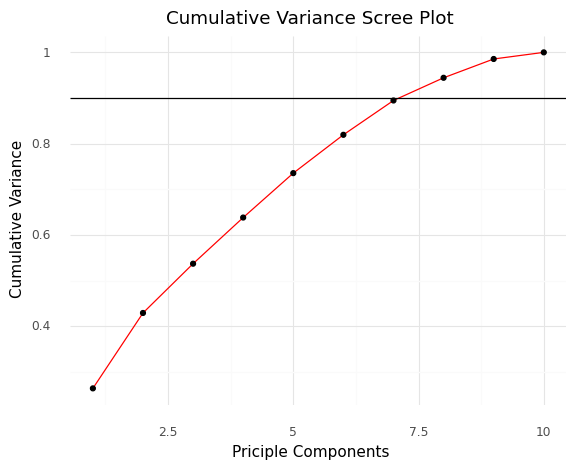

<ggplot: (8761683545613)>

In [29]:
# Cumulative Variance Scree Plot
# We want to choose the number of components based on 90% thresshold of original variability that we want to retain
(ggplot(pcaDF, aes(x = "pc", y = "cum_var")) + geom_line(color = "red") +
    geom_point(color = "black") + geom_hline(yintercept = 0.90) + 
    labs(title = "Cumulative Variance Scree Plot")+ theme_minimal() +
    xlab("Priciple Components") + ylab("Cumulative Variance"))
# looks like 7 principle components at the 90% threshhold

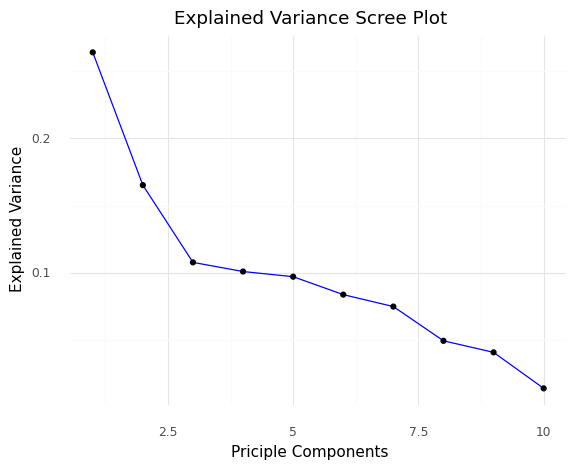

<ggplot: (8761682072561)>

In [30]:
# Explained Variance Scree Plot
# looking for point of inflection
(ggplot(pcaDF, aes(x = "pc", y = "expl_var")) + geom_line(color = "blue") +
    geom_point(color = "black") + 
    labs(title = "Explained Variance Scree Plot")+ theme_minimal() +
    xlab("Priciple Components") + ylab("Explained Variance"))
# looks like 3 priciple components bc the point of inflection is at 3

In [31]:
# for 7 principle components when looking at the cululative variance scree plot
# record the accuracy score for both training/test sets for 7 principle components

pcomps7_train = pca.transform(Xz_train)
pcomps7_train = pd.DataFrame(pcomps7_train[:,0:7])

pcomps7_test = pca.transform(Xz_test)
pcomps7_test = pd.DataFrame(pcomps7_test[:,0:7])

lr2 = LogisticRegression()
lr2.fit(pcomps7_train, yz_train)

print("Linear Regression using PCA Train with 7 Pinciple Components: ", lr2.score(pcomps7_train, yz_train))
print("Linear Regression using PCA Test with 7 Pinciple Components: ", lr2.score(pcomps7_test, yz_test))

Linear Regression using PCA Train with 7 Pinciple Components:  0.7605321507760532
Linear Regression using PCA Test with 7 Pinciple Components:  0.7425742574257426


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [32]:
# for 3 principle components when looking at the cululative variance scree plot
# record the MSE/R2 for both training/test sets for 3 principle components

pcomps3_train = pca.transform(Xz_train)
pcomps3_train = pd.DataFrame(pcomps3_train[:,0:3])

pcomps3_test = pca.transform(Xz_test)
pcomps3_test = pd.DataFrame(pcomps3_test[:,0:3])

lr3 = LogisticRegression()
lr3.fit(pcomps3_train, yz_train)

print("Linear Regression using PCA Train with 3 Pinciple Components: ", lr3.score(pcomps3_train, yz_train))
print("Linear Regression using PCA Test with 3 Pinciple Components: ", lr3.score(pcomps3_test, yz_test))

Linear Regression using PCA Train with 3 Pinciple Components:  0.7605321507760532
Linear Regression using PCA Test with 3 Pinciple Components:  0.7326732673267327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


### What steps I took and why:

Even though there doesn't seem to be much of a relationship between `valence` vs `energy` and `mode`, we would still like to see if there are audio features have a strong realtionship with the `mode`. This will allow us to see if we can only use the variables that heavily affect the `mode` to still accurately predict the `mode` of a song while still retaining most of the information. I trained 2 **Logistic Regression Models** without using **PCA** and with using **PCA** to compare how well each model does by their accuracy scores. **PCA** is a way of rotating the axes of the data to take advantage of the relationships between different variables and create a new set of axes that is very efficient at describing the variation in the data. It is efficient because we are only retaining a handful of our principal components and still covering almost all the information from the original data. This is why it would be interesting to see if our model will be able to retain the same amount of information as was done with all of the original data. Looking at the scree plot, we can identify how much of the information was retained in the model while using fewer components/variables. It might be better for us to use less audio features that are not necessary to the relationship between other audio features. Meaning, it might get rid of unnecessary variables that do not have a significant relationship to the other variables. Instead of having so many audio features with a slight relationship, we want to see if the new sets of axes can describe the variation better than before.

### My findings:

The first graph is cumulative varaince scree plot. Since priciniple components analysis orders the priciniple components from most to least variability explained, the cumulative variance will tell us how much variance does the first few components account for in total. Graphing a cumulative variance scree plot can tell us what the first component is where the cumulative variance exceeds our threshhold 90%. In this case, it seems like 7 is the ideal number of priciple components. We can tell because when the cumulative variance equals 0.9 when priciple components equals 7, we can tell that 90% of the information was retained in the model within the first 7 priciple components. Using just 7 priciple components will actually retain most of the information from the original data. 

In the second scree plot, we are plotting the explained variance scree plot. The explained variance will grab for each of the different components how much variance that specific component accounts for. We can use the elbow method on the explained variance scree plot to to look for the point of inflection on the graph. The point of inflection can tell us up until what components we can keep. In this graph, we can see that the point of inflection is at 3 principle components. Therefore, even with only 3 principle components, we will be able to retain most of the information from the original data.

The performance of the **Logistic Regression Model** built without **PCA** slightly different that the **Logistic Regression Model** built with **PCA**. Although models with 3 and 7 principle components performed slightly better with an accuracy score of around 0.76 for the training set compared to the **Logistic Regression Model** without **PCA** with an accuracy score of around 0.75 for the training set, we can see that the models using **PCA** are a bit overfit. This is because the accuracy score of the training set is higher than the accuracy score of the testing set, which is around 0.73 and 0.74. This means that when we introduce the unseen data to the model, it is not able to as accurately predict the `mode` of a song since the model is too attuned to the data from the training set. 

Even while looking at the cumulative variance scree plot, we can tell that all the audio features have some type of importance in regards to explaining the outcome of `mode`. We can tell because since the graph isn't too steep and the slope between each principle component is quite steady, this means that there are more variables we need to explain the outcome. There are no such variables that have too much of a high relationship with the outcome or `mode` to give us the the necessary information that we can discard the variables that don't affect the `mode`. Therefore since there aren't many variables that with a slight relationship with each other, these new sets of axes created by **PCA** does not accurately describe the variation that much better than before.

### How these findings will affect how we approach recommending songs to our customers:

Even though using priciple cmponents would have allowed us to reduce the complexity of the model, making the model much faster in computation, we are not able to retain as much information with fewer variables while still being able to efficiently describe the variation in the data. **PCA** mainly works best when there is a high correlation between variables. While looking at the scree plots, we can tell that there aren't many variables that are highly correlated, so we need to take in account for all of the varaibles to have a significant impact on the model. This is why, while recommnding songs to our customers based on the `mode`, we need to consider all audio features.